In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import pandas as pd

In [44]:
# Replace these paths with your actual image paths
brightfield_path = "/content/drive/MyDrive/OneDrive_1_6-24-2025/GFP/Day24 VUB01 WT cMYC_Plate_R_p00_0_A01f00d4.TIF"
gfp_path = "/content/drive/MyDrive/OneDrive_1_6-24-2025/GFP/Day24 VUB01 WT cMYC_Plate_R_p00_0_A01f00d1.TIF"

# Load brightfield and GFP images
img_bf = cv2.imread(brightfield_path, cv2.IMREAD_UNCHANGED)
img_bf = cv2.normalize(img_bf, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

img_gfp = cv2.imread(gfp_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

In [45]:
# Preprocess brightfield to extract organoid mask
blurred = cv2.GaussianBlur(img_bf, (11, 11), 0)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

clean = morphology.remove_small_objects(thresh.astype(bool), min_size=20000)
clean = morphology.binary_closing(clean, morphology.disk(5))
labels = measure.label(clean)
props = measure.regionprops(labels)

# Select largest organoid
props_sorted = sorted(props, key=lambda p: p.area, reverse=True)
if not props_sorted:
    raise ValueError("No organoid found.")
org = props_sorted[0]

# Create binary mask
organoid_mask = np.zeros_like(clean, dtype=np.uint8)
organoid_mask[tuple(zip(*org.coords))] = 1

In [46]:
# Extract GFP values inside organoid
gfp_values = img_gfp[organoid_mask == 1]
gfp_min, gfp_max = np.percentile(gfp_values, [1, 99])  # ignore outliers

# Normalize GFP channel within organoid
gfp_normalized = np.clip((img_gfp - gfp_min) / (gfp_max - gfp_min), 0, 1)
gfp_normalized = gfp_normalized * organoid_mask  # mask background

# Threshold GFP to define GFP+ region (adjustable)
gfp_thresh_val = 0.85  # adjust between 0.6 and 0.9 if needed
gfp_positive_mask = (gfp_normalized > gfp_thresh_val).astype(np.uint8)

In [47]:
# Organoid morphology
y0, x0 = org.centroid
area = org.area
perimeter = org.perimeter
circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0

# GFP metrics
gfp_area = np.sum(gfp_positive_mask)
gfp_mean_intensity = np.mean(gfp_normalized[gfp_positive_mask == 1]) if gfp_area > 0 else 0
gfp_total_intensity = np.sum(gfp_normalized[gfp_positive_mask == 1]) if gfp_area > 0 else 0

# Store in DataFrame
df = pd.DataFrame([{
    "centroid_x": round(x0, 2),
    "centroid_y": round(y0, 2),
    "area": round(area, 2),
    "perimeter": round(perimeter, 2),
    "circularity": round(circularity, 4),
    "gfp_positive_area": int(gfp_area),
    "gfp_mean_intensity": round(gfp_mean_intensity, 4),
    "gfp_total_intensity": round(gfp_total_intensity, 4)
}])

# Display and optionally export
print(df)
df.to_csv("/content/drive/My Drive/Imaging/organoid_gfp_analysis.csv", index=False)

   centroid_x  centroid_y      area  perimeter  circularity  \
0      984.58       772.4  312357.0    2298.72       0.7428   

   gfp_positive_area  gfp_mean_intensity  gfp_total_intensity  
0               7606              0.9524            7243.9535  


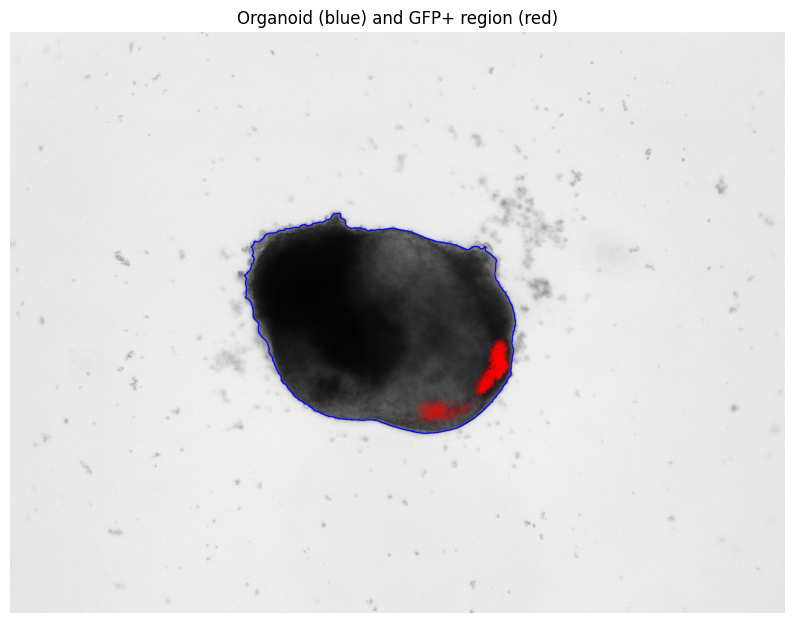

In [48]:
# Convert BF to color
overlay = cv2.cvtColor(img_bf, cv2.COLOR_GRAY2BGR)

# Draw red where GFP+ is present
overlay[gfp_positive_mask.astype(bool)] = [255, 0, 0]  # Red

# Draw blue contour around organoid
contours, _ = cv2.findContours(organoid_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (0, 0, 255), 2)  # Blue outline

# Show overlay
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title("Organoid (blue) and GFP+ region (red)")
plt.axis("off")
plt.show()